In [1]:
# -*- coding: utf-8 -*-
# pylint: disable=invalid-name

In [2]:
%load_ext autoreload

In [3]:
%autoreload 2

In [4]:
from spectral import *
import numpy as np
import scipy.spatial.distance as distance
import pylab
import spectral.io.envi as envi
import random
from scipy.spatial.distance import cdist
from sklearn.cluster import KMeans
from timeit import default_timer as timer

In [5]:
from autoclustering import find_maxdist_clusters
from hiersubclustering import subdivide_by_modules
from visual_utils import show_classes, show_histogram, show_centers
from math_utils import cluster_histogram, normalized

Читаем изображение.

In [6]:
#img = open_image('92AV3C.lan')
# gt = open_image('92AV3GT.GIS').read_band(0)
img = envi.open('f080611t01p00r07rdn_c_sc01_ort_img.hdr')

In [7]:
print(img)

	Data Source:   '/home/marko/HSI/f080611t01p00r07rdn_c/f080611t01p00r07rdn_c_sc01_ort_img'
	# Rows:           1924
	# Samples:         753
	# Bands:           224
	Interleave:        BIP
	Quantization:  16 bits
	Data format:     int16


Число каналов:  224
Минимальная длина волн:  365.9298
Максимальная длина волн:  2497.036


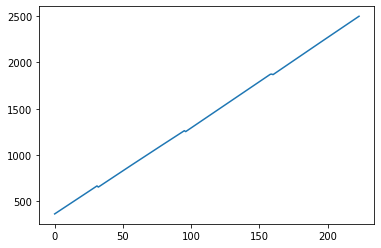

In [8]:
wavelengths_original = np.array(img.bands.centers)
print('Число каналов: ', len(wavelengths_original))
print('Минимальная длина волн: ', min(wavelengths_original))
print('Максимальная длина волн: ', max(wavelengths_original))
pylab.plot(wavelengths_original)

Видно что на трёх местах длина волн не возрастает монотонно. В частности, на 32ом элементе падает.

In [9]:
print(wavelengths_original[28:38])

[638.1865 647.9736 657.7651 667.561  655.2923 665.0994 674.9012 684.6979
 694.4894 704.2756]


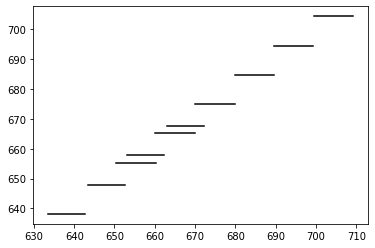

In [10]:
local_wl_centers = np.array(img.bands.centers[28:38])
local_bandwidths = np.array(img.bands.bandwidths[28:38])
band_starts = local_wl_centers - local_bandwidths / 2
band_ends = local_wl_centers + local_bandwidths / 2

pylab.figure()
for (c, s, e) in zip(local_wl_centers, band_starts, band_ends):
    pylab.plot([s, e], [c, c], color='black')

pylab.show()

Кроме того что они не в возрастающем порядке, они также значительно пересекаются. Отсортируем их.

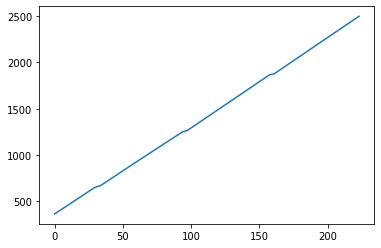

In [11]:
wavelengths_sorted = np.sort(wavelengths_original)
pylab.plot(wavelengths_sorted)

In [12]:
some_signature = img[1220, 496].astype(float)
resampler = BandResampler(wavelengths_original, wavelengths_sorted, img.bands.bandwidths)
some_signature_resampled = resampler(some_signature)

Посмотрим как выглядят графики, оригинальный, с отсортированными длинами волн, и с отсортированными длинами волн и соответствующей корректировкой измерений.

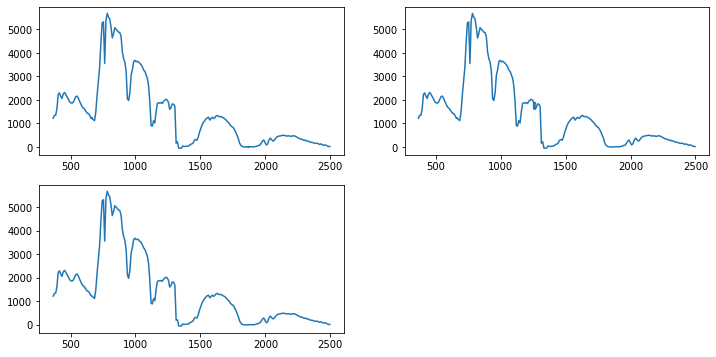

In [13]:
fig = pylab.figure()
fig.set_size_inches(3*4, 1*6)
pylab.subplot(2, 2, 1)
pylab.plot(wavelengths_original, some_signature)
pylab.subplot(2, 2, 2)
pylab.plot(wavelengths_sorted, some_signature)
pylab.subplot(2, 2, 3)
pylab.plot(wavelengths_sorted, some_signature_resampled)
pylab.show()

Посмотрим часть которая нам была интересной сначала.

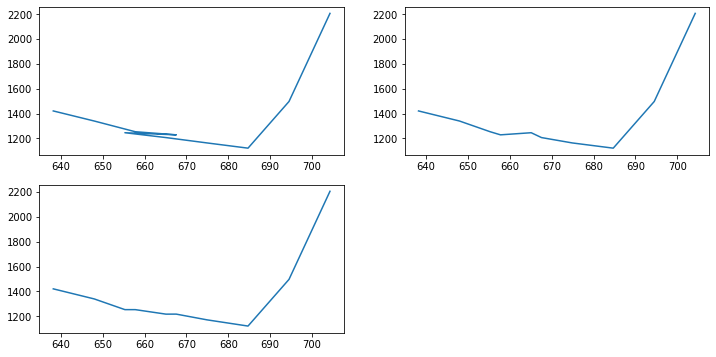

In [14]:
fig = pylab.figure()
fig.set_size_inches(3*4, 1*6)
pylab.subplot(2, 2, 1)
pylab.plot(wavelengths_original[28:38], some_signature[28:38])
pylab.subplot(2, 2, 2)
pylab.plot(wavelengths_sorted[28:38], some_signature[28:38])
pylab.subplot(2, 2, 3)
pylab.plot(wavelengths_sorted[28:38], some_signature_resampled[28:38])
pylab.show()

Видно что сортировка помогла. Посмотрим ещё одну интересную часть.

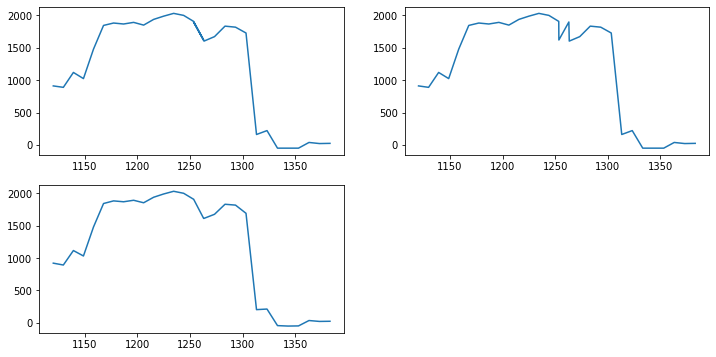

In [15]:
fig = pylab.figure()
fig.set_size_inches(3*4, 1*6)
pylab.subplot(2, 2, 1)
pylab.plot(wavelengths_original[80:110], some_signature[80:110])
pylab.subplot(2, 2, 2)
pylab.plot(wavelengths_sorted[80:110], some_signature[80:110])
pylab.subplot(2, 2, 3)
pylab.plot(wavelengths_sorted[80:110], some_signature_resampled[80:110])
pylab.show()

Тут ещё видно что нам нужно ещё и значения скорректировать. Поэтому, исправим целое изображение.

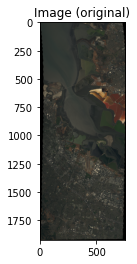

In [16]:
view = imshow(img, (29, 20, 12), title="Image (original)")

In [17]:
data = img[:,:,:]
#data = img[400:1000, 200:, :]
#data = img[400:700, 200:400, :]

In [18]:
data[data <= 0] = 1
print(data.dtype)

>i2


In [19]:
img_width = data.shape[0]
img_height = data.shape[1]
img_depth = data.shape[2]
data = np.dot(data.reshape(img_width*img_height, img_depth), resampler.matrix.T)
data = data.reshape(img_width, img_height, img_depth)

In [255]:
wavelengths = wavelengths_sorted
wavelengths_um = wavelengths / 1000

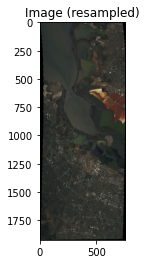

In [21]:
view = imshow(data, (29, 20, 12), title="Image (resampled)")

Будем проверять работу алгоритмов используя несколько интересных сигнатур.

1. Травы
2. Асфальта
3. Морской воды
4. Бетона

Надо упомянуть что особенно травы и воды могут быть разные. Вода может быть в большей или меньшей степени загрязненной, трава свежей или сухой, итд. Все ниже выбранные сигнатуры находятся около самого аэродрома.

In [22]:
interesting_signatures = [data[1220, 496].astype(float),
                          data[1227, 423].astype(float),
                          data[1177, 505].astype(float),
                          data[1258, 499].astype(float),
                         ]

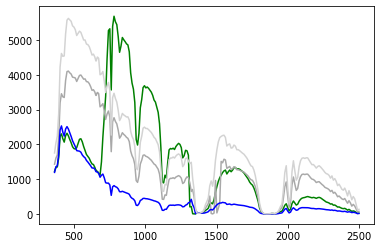

In [23]:
from visual_utils import draw_ontop
draw_ontop(interesting_signatures, wavelengths, ['green', 'darkgrey', 'blue', 'lightgrey'])

Проверим работу функции удаления континуума написанных на С.

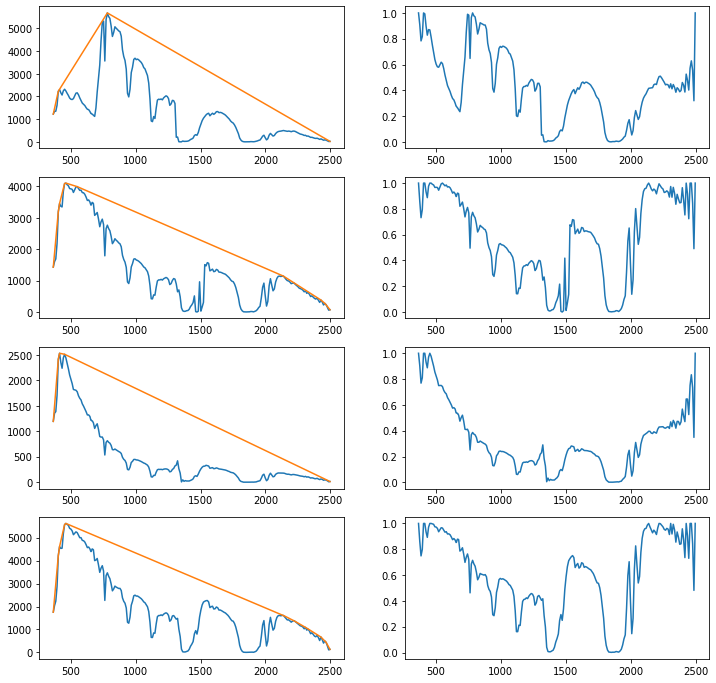

In [24]:
from continuum import continuum, continuum_removed
from visual_utils import draw_common_2cols_graphs
inarr = np.asarray(interesting_signatures)
outarr = np.empty_like(inarr)
outarr_rem = np.empty_like(inarr)
continuum(inarr, outarr, wavelengths)
continuum_removed(inarr, outarr_rem, wavelengths)

graphs = []

for i in range(inarr.shape[0]):
    graphs.append([
        [inarr[i], outarr[i]],
        [outarr_rem[i]]
    ])

draw_common_2cols_graphs(graphs, wavelengths)

Проверим работу функции удаления континуума на питоне.

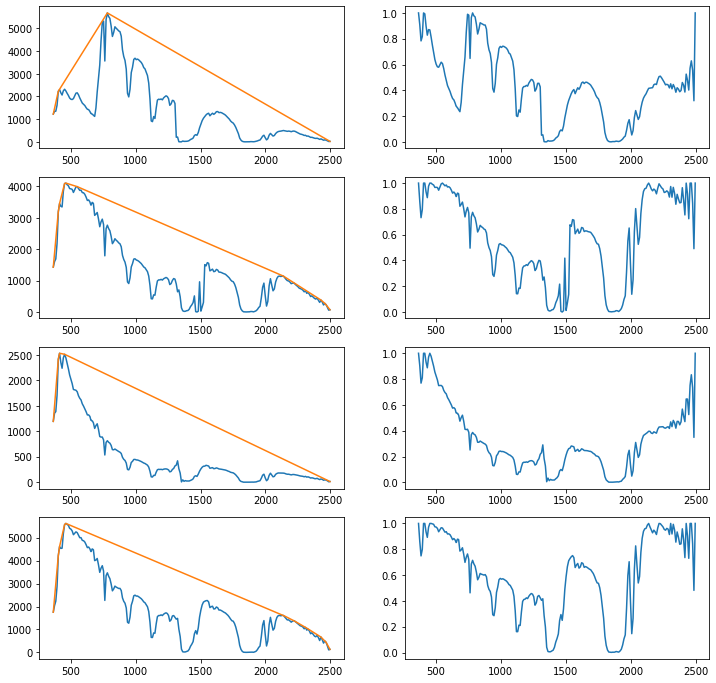

In [25]:
from pycontinuum import pycontinuum, pycontinuum_removed
from visual_utils import draw_common_2cols_graphs

graphs = []

for isig in interesting_signatures:
    cont = pycontinuum(isig, wavelengths)
    cont_removed = pycontinuum_removed(isig, cont)
    graphs.append([
        [isig, cont],
        [cont_removed]
    ])

draw_common_2cols_graphs(graphs, wavelengths)

Проверим работу функции вычисления частичного континуума на питоне.

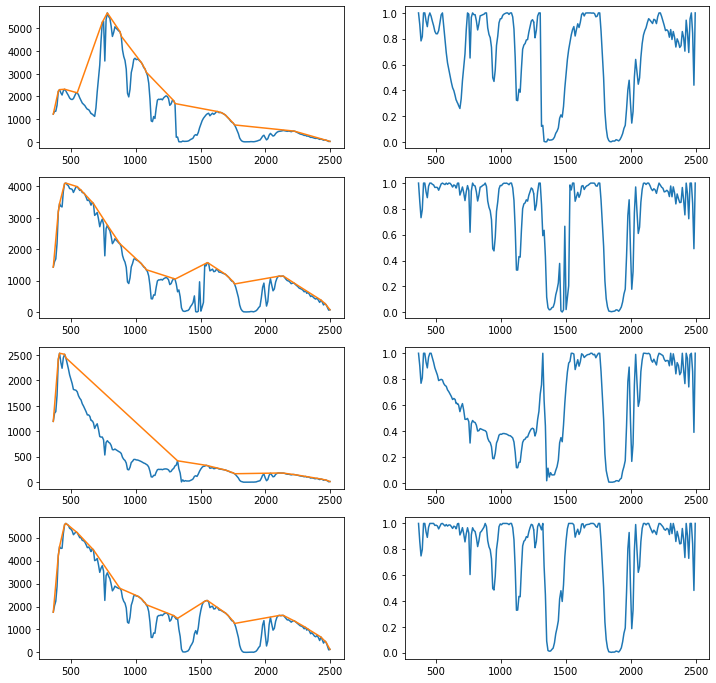

In [26]:
from pycontinuum import pypartial_continuum, pycontinuum_removed
from visual_utils import draw_common_2cols_graphs
step = 8
graphs = []

for isig in interesting_signatures:
    cont = pypartial_continuum(isig, wavelengths, step)
    cont_removed = pycontinuum_removed(isig, cont)
    graphs.append([
        [isig, cont],
        [cont_removed]
    ])

draw_common_2cols_graphs(graphs, wavelengths)

Также Б-сплайны с частичными континуумами.

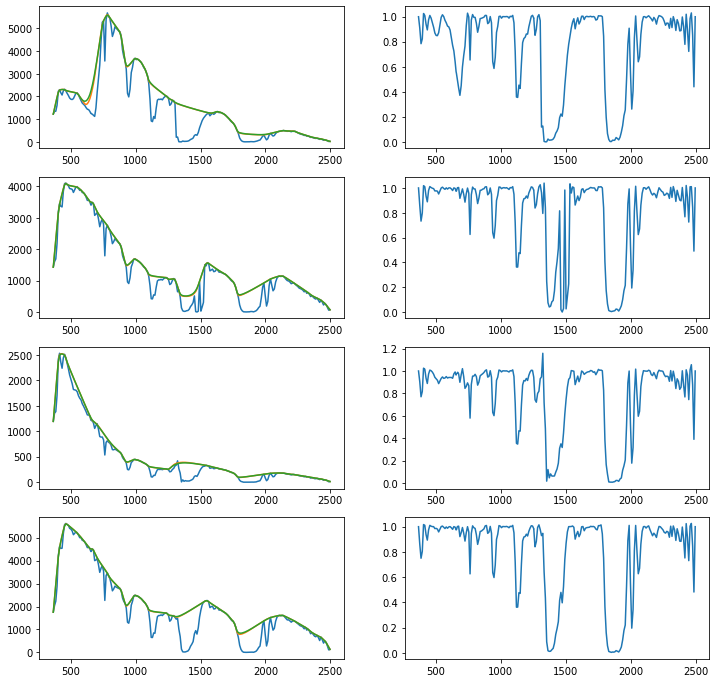

In [27]:
from pycontinuum import pypartial_continuum, pycontinuum_removed, pypartial_continuum_points
from custo_math_funcs import bspline3_from_points, bspline2_from_points
from visual_utils import draw_common_2cols_graphs
step = 2
graphs = []

for isig in interesting_signatures:
    cont = pypartial_continuum(isig, wavelengths, step)
    points = pypartial_continuum_points(isig, wavelengths, step)
    cont_bspline2 = bspline2_from_points(points, wavelengths)
    cont_bspline3 = bspline3_from_points(points, wavelengths)
    cont_removed = pycontinuum_removed(isig, cont_bspline3)
    graphs.append([
        [isig, cont_bspline2, cont_bspline3],
        [cont_removed]
    ])

draw_common_2cols_graphs(graphs, wavelengths)

Kусочно-полиномиальная квадратичная интерполяция (piecewise quadratic polynomial interpolation, interpolating B-Spline)

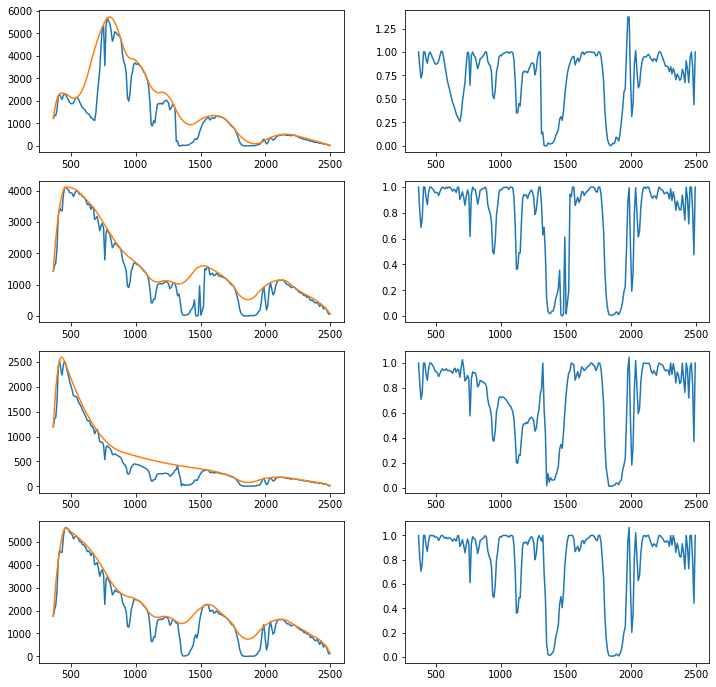

In [28]:
from pycontinuum import pypartial_continuum, pycontinuum_removed, pypartial_continuum_points, interpolate_points
from visual_utils import draw_common_2cols_graphs
step = 8
graphs = []

for isig in interesting_signatures:
    cont = pypartial_continuum(isig, wavelengths, step)
    points = pypartial_continuum_points(isig, wavelengths, step)
    interp_continuum  = interpolate_points(points, wavelengths, kind='quadratic')
    cont_removed = pycontinuum_removed(isig, interp_continuum)
    graphs.append([
        [isig, interp_continuum],
        [cont_removed]
    ])

draw_common_2cols_graphs(graphs, wavelengths)

Посмотрим какие результаты получим после применения фильтра в частотной области.

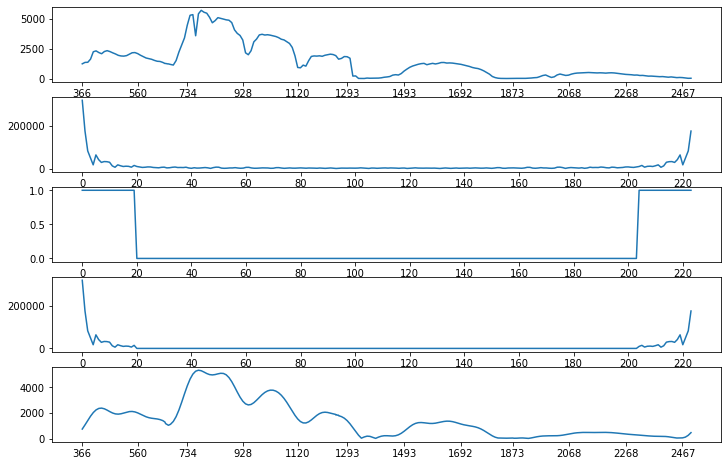

In [29]:
from scipy.fft import fft, ifft
from math_utils import square_signals
from visual_utils import draw_common_vert_plots

isig = interesting_signatures[0]
freq_domain = fft(isig)

stepf = square_signals(len(freq_domain), [(0, 20), (-20, len(freq_domain))])
filtered_freq = freq_domain * stepf

rsig = ifft(filtered_freq)

wl_xticks = wavelengths[::20]
length_xs = np.arange(len(wavelengths))
len_xticks = np.arange(0, len(wavelengths), 20)

graphs = [
    {'x': wavelengths, 'y': isig, 'xticks': wl_xticks},
    {'x': length_xs, 'y': np.abs(freq_domain), 'xticks': len_xticks},
    {'x': length_xs, 'y': stepf, 'xticks': len_xticks},
    {'x': length_xs, 'y': np.abs(filtered_freq), 'xticks': len_xticks},
    {'x': wavelengths, 'y': np.abs(rsig), 'xticks': wl_xticks},
]

draw_common_vert_plots(graphs)

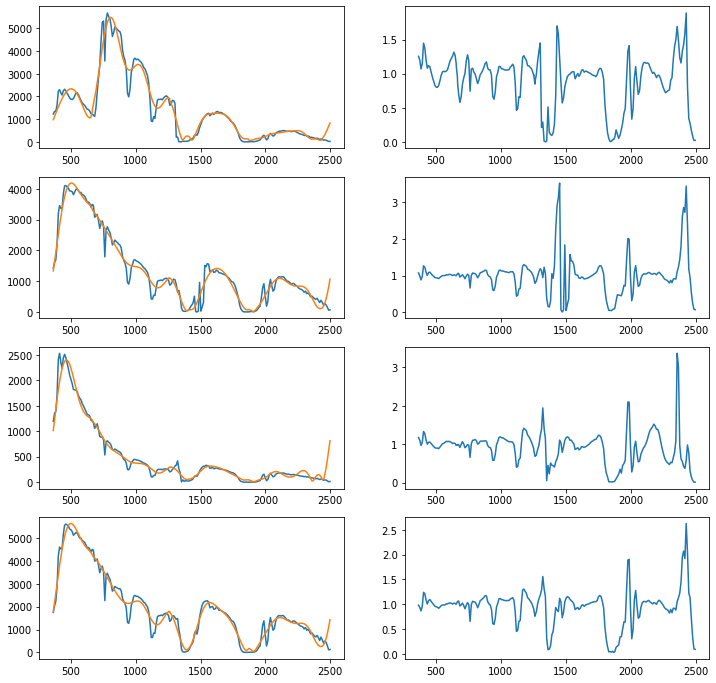

In [30]:
from math_utils import freq_square_filter
from visual_utils import draw_common_2cols_graphs
from pycontinuum import pycontinuum_removed

graphs = []

take_n_outer = 10

for isig in interesting_signatures:
    rsig = freq_square_filter(isig, [(0, take_n_outer), (-take_n_outer, len(isig))])
    cont_removed = pycontinuum_removed(isig, rsig)
    graphs.append([
        [isig, rsig],
        [cont_removed]
    ])

draw_common_2cols_graphs(graphs, wavelengths)

Посмотрим какие результаты получим после применения фильтра скользящее среднее.

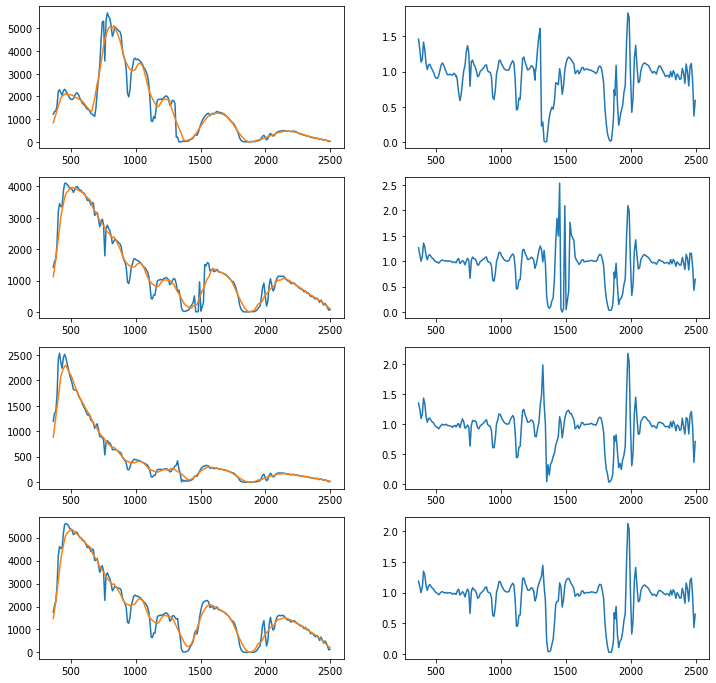

In [31]:
from math_utils import moving_average_filter
from visual_utils import draw_common_2cols_graphs
from pycontinuum import pycontinuum_removed

graphs = []
avg_window = 12

for isig in interesting_signatures:
    rsig = moving_average_filter(isig, avg_window)
    cont_removed = pycontinuum_removed(isig, rsig)
    graphs.append([
        [isig, rsig],
        [cont_removed]
    ])

draw_common_2cols_graphs(graphs, wavelengths)

Находим характерные сигнатуры изображения - максимумы, средние, самые удалённые от средней.

In [32]:
from utils import filter_out_invalid_signatures
sigs = filter_out_invalid_signatures(data)

In [33]:
avg = np.average(sigs, axis=0)
cr_avg = pycontinuum_removed(avg, pycontinuum(avg, wavelengths))

In [34]:
maxes = np.max(sigs, axis=0)
cr_maxes = pycontinuum_removed(maxes, pycontinuum(maxes, wavelengths))

In [35]:
from math_utils import find_max_diff_l2
max_diff_l2 = find_max_diff_l2(sigs, avg)
cr_max_diff_l2 = pycontinuum_removed(max_diff_l2, pycontinuum(max_diff_l2, wavelengths))

In [36]:
from math_utils import find_max_diff_l1
max_diff_l1 = find_max_diff_l1(sigs, avg)
cr_max_diff_l1 = pycontinuum_removed(max_diff_l1, pycontinuum(max_diff_l1, wavelengths))

In [37]:
from math_utils import find_max_diff_angle
max_diff_angle = find_max_diff_angle(sigs, avg)
cr_max_diff_angle = pycontinuum_removed(max_diff_angle, pycontinuum(max_diff_angle, wavelengths))

In [38]:
from math_utils import find_with_max_norm2
max_norm2 = find_with_max_norm2(sigs)
cr_max_norm2 = pycontinuum_removed(max_norm2, pycontinuum(max_norm2, wavelengths))

In [39]:
from math_utils import find_with_max_norm1
max_norm1 = find_with_max_norm1(sigs)
cr_max_norm1 = pycontinuum_removed(max_norm1, pycontinuum(max_norm1, wavelengths))

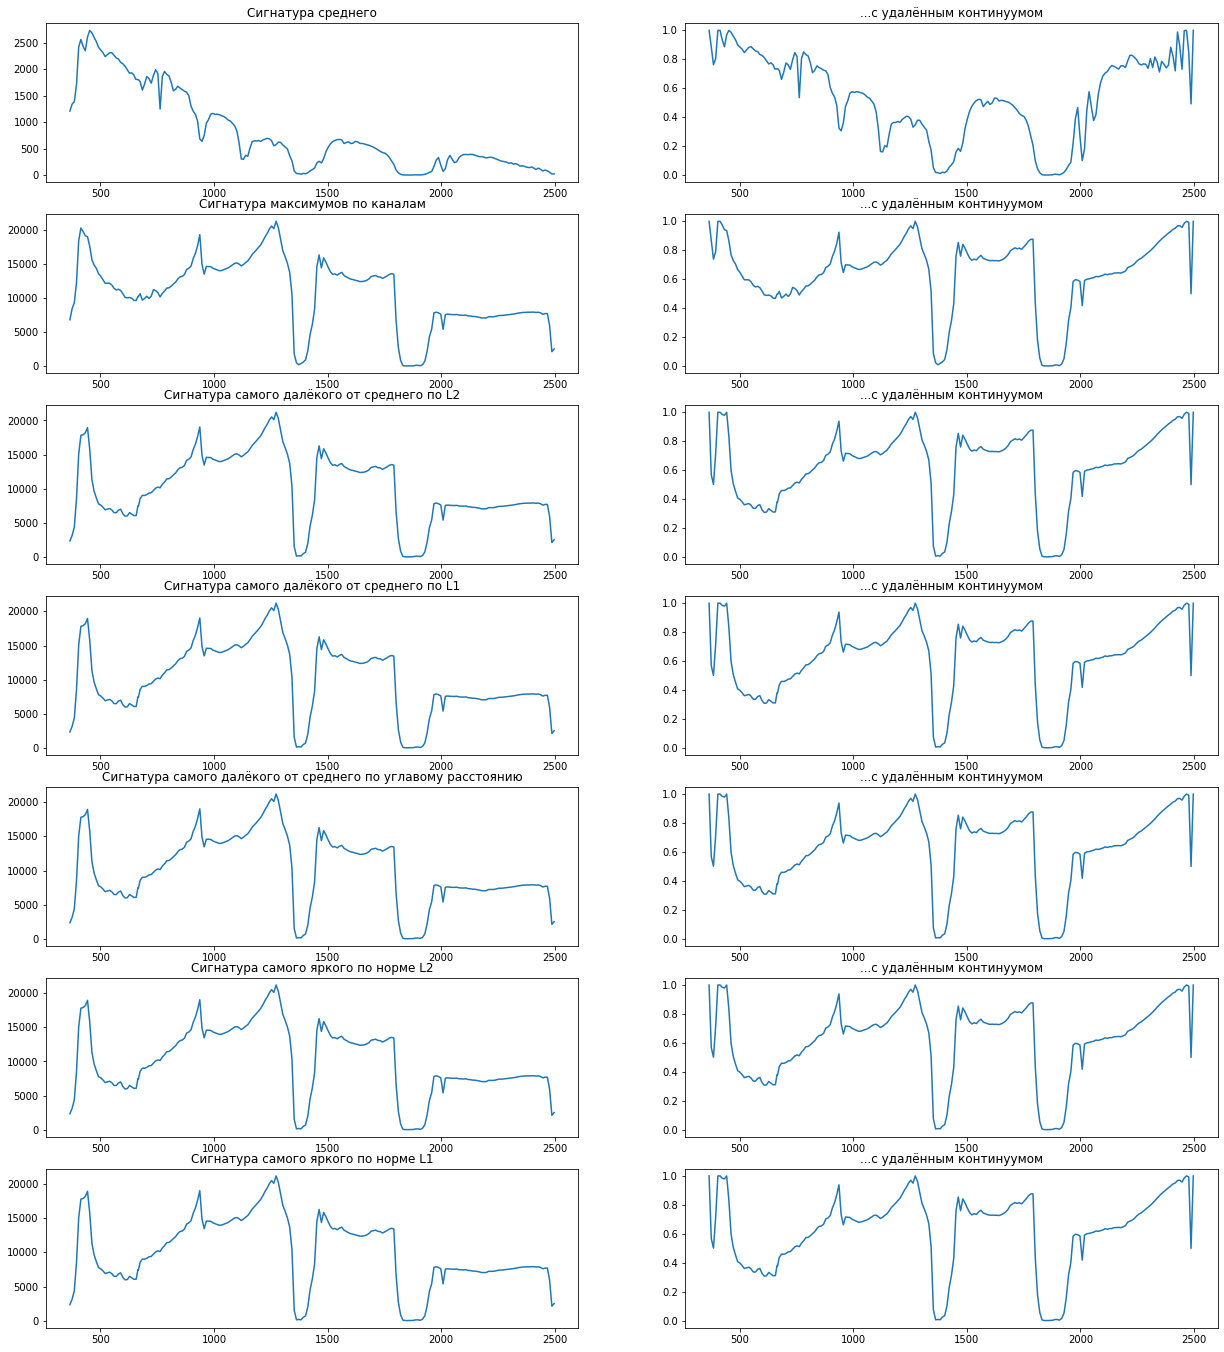

In [40]:
figs = [
    {
     'title': 'Сигнатура среднего',
     'sig': avg,
     'cr-title': '...с удалённым континуумом',
     'cr-sig': cr_avg
    },
    {
     'title': 'Сигнатура максимумов по каналам',
     'sig': maxes,
     'cr-title': '...с удалённым континуумом',
     'cr-sig': cr_maxes
    },
    {
     'title': 'Сигнатура самого далёкого от среднего по L2',
     'sig': max_diff_l2,
     'cr-title': '...с удалённым континуумом',
     'cr-sig': cr_max_diff_l2
    },
    {
     'title': 'Сигнатура самого далёкого от среднего по L1',
     'sig': max_diff_l1,
     'cr-title': '...с удалённым континуумом',
     'cr-sig': cr_max_diff_l1
    },
    {
     'title': 'Сигнатура самого далёкого от среднего по углавому расстоянию',
     'sig': max_diff_angle,
     'cr-title': '...с удалённым континуумом',
     'cr-sig': cr_max_diff_angle
    },
    {
     'title': 'Сигнатура самого яркого по норме L2',
     'sig': max_norm2,
     'cr-title': '...с удалённым континуумом',
     'cr-sig': cr_max_norm2
    },
    {
     'title': 'Сигнатура самого яркого по норме L1',
     'sig': max_norm1,
     'cr-title': '...с удалённым континуумом',
     'cr-sig': cr_max_norm1
    }
]


fig = pylab.figure()
fig.set_size_inches(len(figs)*3, 2*12)

for i in range(len(figs)):
    ax = pylab.subplot(len(figs), 2, (i*2)+1)
    ax.set_title(figs[i]['title'])
    pylab.plot(wavelengths, figs[i]['sig'])
    ax = pylab.subplot(len(figs), 2, (i*2)+2)
    ax.set_title(figs[i]['cr-title'])
    pylab.plot(wavelengths, figs[i]['cr-sig'])

pylab.show()

Посмотрим где находится самая отличающаяся сигнатура.

In [41]:
from utils import find_image_coords_of_signature
coords = find_image_coords_of_signature(data, max_diff_l2)
print(coords)

(1315, 98)


Посмотрим как будет выглядет если удалят континуум на основе (Б-сплайна) максимумов.

[(365.9298, 6794.926544337634), (404.6129, 18352.428152270335), (414.2946, 20226.0), (1273.318, 21204.723878025798), (2467.273, 7700.586365329233), (2497.036, 2519.5860611854832)]


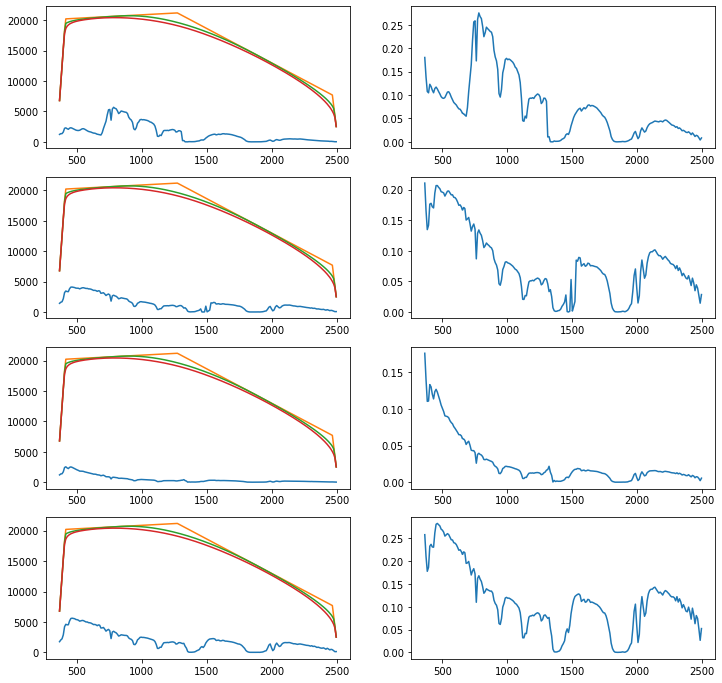

In [42]:
from pycontinuum import pycontinuum, pycontinuum_removed, pycontinuum_points
from custo_math_funcs import bspline3_from_points, bspline2_from_points
from visual_utils import draw_common_2cols_graphs

graphs = []
cont = pycontinuum(maxes, wavelengths)
cont_points = pycontinuum_points(maxes, wavelengths)
print(cont_points)
cont_bspline2 = bspline2_from_points(cont_points, wavelengths)
cont_bspline3 = bspline3_from_points(cont_points, wavelengths)

for isig in interesting_signatures:
    cont_removed = pycontinuum_removed(isig, cont_bspline2)
    graphs.append([
        [isig, cont, cont_bspline2, cont_bspline3],
        [cont_removed]
    ])

draw_common_2cols_graphs(graphs, wavelengths)

Kусочно-полиномиальная квадратичная интерполяция (piecewise quadratic polynomial interpolation, interpolating B-Spline)

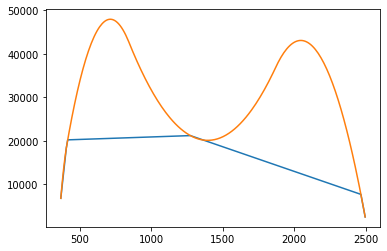

In [43]:
from pycontinuum import pycontinuum, pycontinuum_removed, pycontinuum_points, interpolate_points
cont = pycontinuum(maxes, wavelengths)
cont_points = pycontinuum_points(maxes, wavelengths)
cont_interp = interpolate_points(cont_points, wavelengths, kind='quadratic')
pylab.plot(wavelengths, cont)
pylab.plot(wavelengths, cont_interp)

Кажется лучше просто взять простой линейный континуум сигнатуры максимумов и будем удалять континуум на его основе и сравнивать с эталонами. Хотя, провалы на некоторых местах в спектре могут испортить результат. Поэтому посмотрим что получится если просто разделить сигнатуры на поканальные максимумы.

Характеристики разных материалов очевидно содержаны в низкочастотным слагаемым. Поэтому,  стоит отфильтровать сигнатуры до, либо после удаления континуума, чтобы избавиться от высокочастотного шума. На взгляд кажется что простой вариант с скользящим средним работает хорошо.

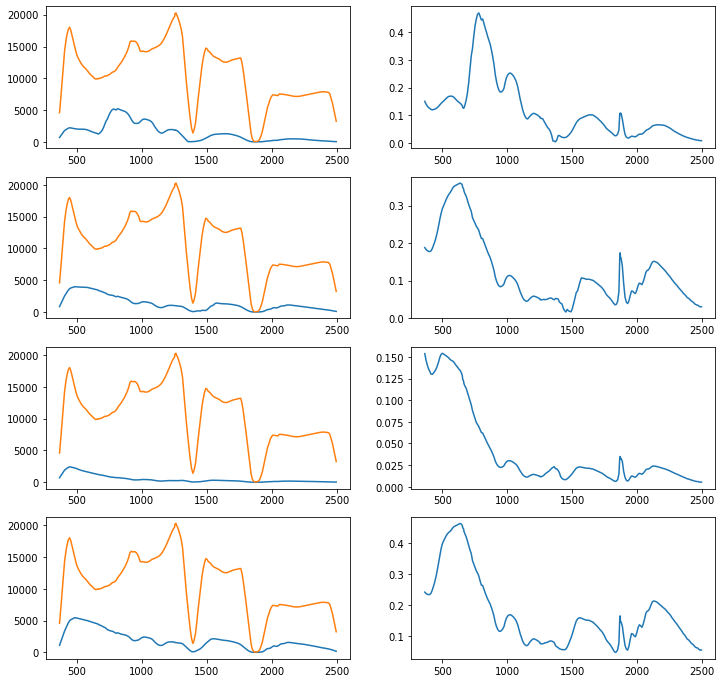

In [44]:
from pycontinuum import pycontinuum, pycontinuum_removed
from visual_utils import draw_common_2cols_graphs
from math_utils import moving_average_filter

graphs = []
avg_window = 8

maxes_filtered = moving_average_filter(maxes, avg_window)

for isig in interesting_signatures:
    isig = moving_average_filter(isig, avg_window)
    cont_removed = pycontinuum_removed(isig, maxes_filtered)
    #cont_removed_filtered = moving_average_filter(cont_removed, avg_window)
    graphs.append([
        [isig, maxes_filtered],
        [cont_removed]
    ])

draw_common_2cols_graphs(graphs, wavelengths)

Провалы в максимумах дают блики в результате. Поэтому определить отражаемость придется другим способом. Частичный континуум + квадратичная интерполяция на глаз дают хороший график. Попробуем. Но попробуем потом и что нибудь более на точной науке обосновано.

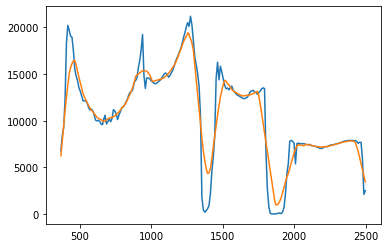

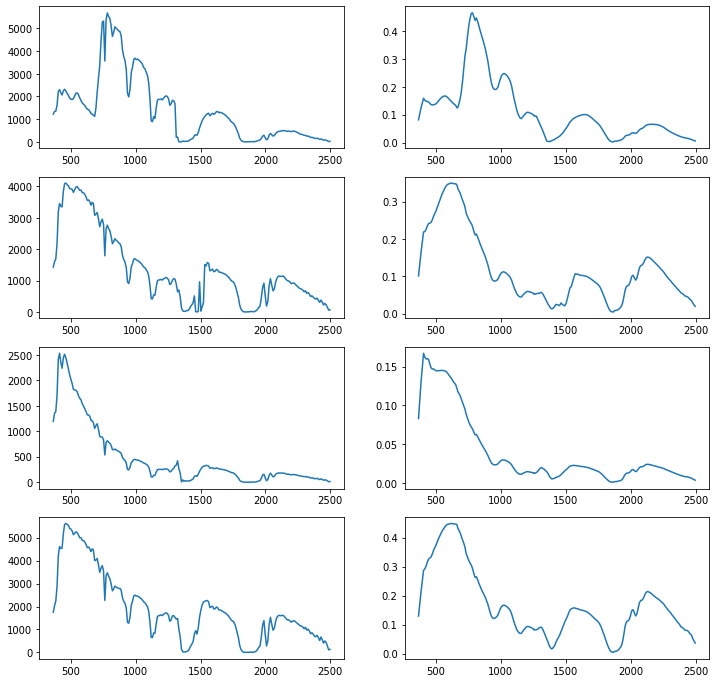

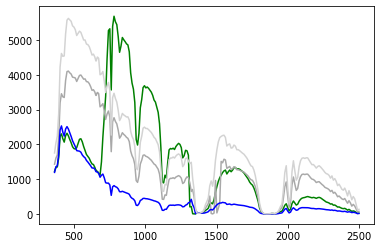

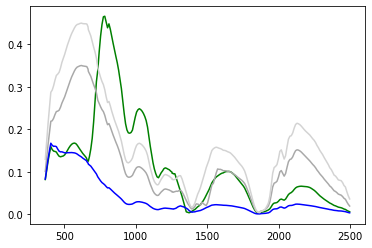

In [202]:
from pycontinuum import pycontinuum, pycontinuum_removed, pypartial_continuum_points, interpolate_points
from visual_utils import draw_common_2cols_graphs, draw_ontop
from math_utils import moving_average_filter

graphs = []
avg_window = 8
step = 1

cont_points = pypartial_continuum_points(maxes, wavelengths, step)
maxes_lin_interp = interpolate_points(cont_points, wavelengths, kind='slinear')
maxes_processed = moving_average_filter(np.clip(maxes, 1000, 20000), 12)

draw_ontop([maxes, maxes_processed], wavelengths)

reflectances = []

for isig in interesting_signatures:
    #isig = moving_average_filter(isig, avg_window)
    cont_removed = pycontinuum_removed(isig, maxes_processed)
    cont_removed_filtered = moving_average_filter(cont_removed, avg_window)
    graphs.append([
        [isig],
        [cont_removed_filtered]
    ])
    reflectances.append(cont_removed_filtered)

draw_common_2cols_graphs(graphs, wavelengths)

draw_ontop(interesting_signatures, wavelengths, ['green', 'darkgrey', 'blue', 'lightgrey'])
draw_ontop(reflectances, wavelengths, ['green', 'darkgrey', 'blue', 'lightgrey'])

Читаем эталон травы (40% сухая, 60% зеленая) снят спектрометром Бэкман. В конце интерполируем невалидные значения.

splib07a Record=24163: Grass_dry.4+.6green AMX27 BECKa AREF 	 480 channels


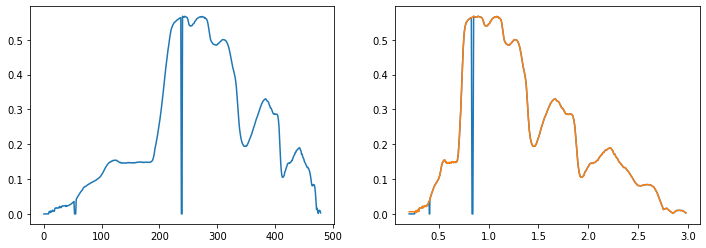

In [234]:
from gsus_splib_utils import SpectralData
grassa_ethalon = SpectralData.read_from_file('grass/splib07a_Grass_dry.4+.6green_AMX27_BECKa_AREF.txt')
grassa_ethalon.replace_invalid(0.0)
print(grassa_ethalon)
pylab.figure().set_size_inches(12, 4)
pylab.subplot(1, 2, 1)
pylab.plot(grassa_ethalon.signature)
pylab.subplot(1, 2, 2)
pylab.plot(grassa_ethalon.spectrometer_data.wavelengths, grassa_ethalon.signature)
grassa_ethalon.interpolate_invalid()
pylab.plot(grassa_ethalon.spectrometer_data.wavelengths, grassa_ethalon.signature)
pylab.show()

Посмотрим как выглядят длины волн.

splib07a Record=20: Bandpass BECK BECK Beckman in microns 	 wavelengths from 0.2051 to 2.9760001
splib07a Record=89: Bandpass AVIRIS AVIRIS 1996 in microns 	 wavelengths from 0.37049001 to 2.5075898


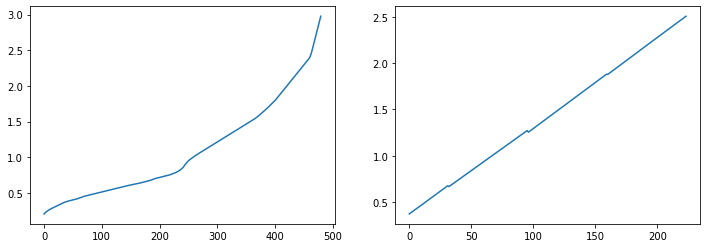

In [235]:
from gsus_splib_utils import SpectrometerData
fig = pylab.figure()
fig.set_size_inches(12, 4)
pylab.subplot(1, 2, 1)
beck_sm = SpectrometerData.get_by_name('BECK')
print(beck_sm)
pylab.plot(beck_sm.wavelengths)
pylab.subplot(1, 2, 2)
aviris_sm = SpectrometerData.get_by_name('AVIRIS')
print(aviris_sm)
pylab.plot(aviris_sm.wavelengths)
pylab.show()

С авирисом известная проблема. Его надо исправлять.

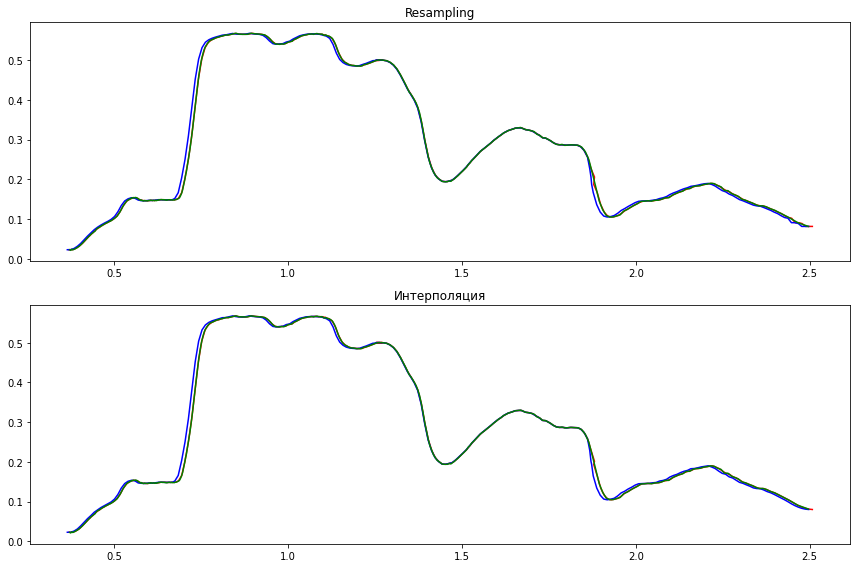

In [256]:
import gsus_splib_utils

fig = pylab.figure()
fig.set_size_inches(12, 8)
fig.set_tight_layout(True)

beck_av_range_wl, beck_av_range_sig = grassa_ethalon.in_range_of('AVIRIS')

as_aviris = grassa_ethalon.resample_as('AVIRIS', True)
pylab.subplot(2, 1, 1).set_title('Resampling')
pylab.plot(SpectrometerData.get_by_name('AVIRIS').wavelengths, as_aviris, color='red')
pylab.plot(wavelengths_um, as_aviris, color='blue')
pylab.plot(beck_av_range_wl, beck_av_range_sig, color='green')

as_aviris = grassa_ethalon.interpolate_as('AVIRIS', True)
pylab.subplot(2, 1, 2).set_title('Интерполяция')
pylab.plot(SpectrometerData.get_by_name('AVIRIS').wavelengths, as_aviris, color='red')
pylab.plot(wavelengths_um, as_aviris, color='blue')
pylab.plot(beck_av_range_wl, beck_av_range_sig, color='green')

pylab.show()

Оба метода га глаз дают одинаково хороший результат. Получаем идеальное совпадение, но длины волн из ENVI не совпадают.

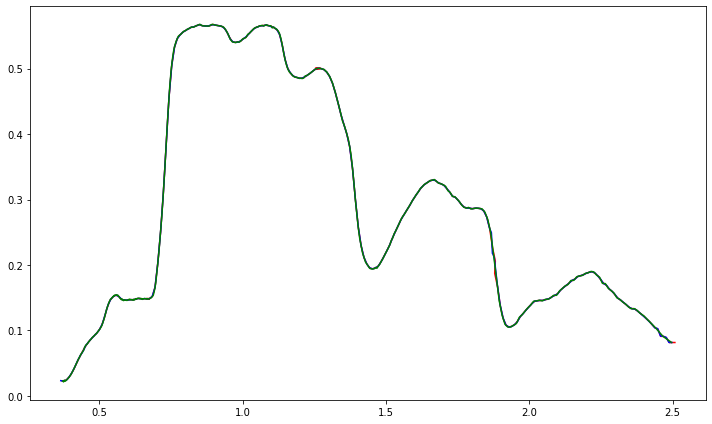

In [257]:
import gsus_splib_utils

fig = pylab.figure()
fig.set_size_inches(10, 6)
fig.set_tight_layout(True)

as_aviris = grassa_ethalon.resample_as('AVIRIS', True)
pylab.plot(SpectrometerData.get_by_name('AVIRIS').wavelengths, as_aviris, color='red')

as_aviris = grassa_ethalon.resample_at(wavelengths_um)
pylab.plot(wavelengths_um, as_aviris, color='blue')

beck_av_range_wl, beck_av_range_sig = grassa_ethalon.in_range_of('AVIRIS')
pylab.plot(beck_av_range_wl, beck_av_range_sig, color='green')

pylab.show()

Отдельной интерполяцией длинами волн из ENVI получаем идеальное совпадение.

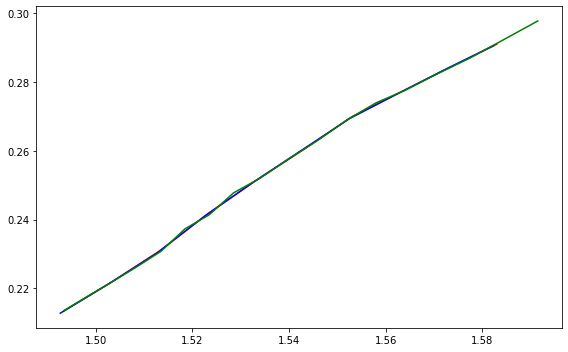

In [258]:
import gsus_splib_utils
from utils import lower_bound, upper_bound

fig = pylab.figure()
fig.set_size_inches(8, 5)
fig.set_tight_layout(True)

min_index = 120
max_index = 130
usgs_av_wavelengths = SpectrometerData.get_by_name('AVIRIS').wavelengths

as_aviris = grassa_ethalon.resample_as('AVIRIS', True)
pylab.plot(usgs_av_wavelengths[min_index:max_index], as_aviris[min_index:max_index], color='red')

as_aviris = grassa_ethalon.resample_at(wavelengths_um)
pylab.plot(wavelengths_um[min_index:max_index], as_aviris[min_index:max_index], color='blue')

beck_av_range_wl, beck_av_range_sig = grassa_ethalon.in_range_of('AVIRIS')
min_index = lower_bound(beck_av_range_wl, usgs_av_wavelengths[min_index])
max_index = upper_bound(beck_av_range_wl, usgs_av_wavelengths[max_index])
pylab.plot(beck_av_range_wl[min_index:max_index], beck_av_range_sig[min_index:max_index], color='green')

pylab.show()

...ну, не 100%. Но теперь знаем начальные шаги для сравнения сигнатур изображения и эталона.

In [249]:
def img2refect(img_sig, filter_step=8, continuum=maxes_processed):
    return moving_average_filter(pycontinuum_removed(img_sig, continuum), filter_step)

In [286]:
def compare_plots_with_ethalon(ethalon, ethalong_color):
    from pycontinuum import pycontinuum, pycontinuum_removed
    grass_img_ref = img2refect(interesting_signatures[0], continuum=maxes_processed)
    asphalt_img_ref = img2refect(interesting_signatures[1], continuum=maxes_processed)
    water_img_ref = img2refect(interesting_signatures[2], continuum=maxes_processed)
    concerete_img_ref = img2refect(interesting_signatures[3], continuum=maxes_processed)

    sigs = [ethalon, grass_img_ref, asphalt_img_ref, water_img_ref, concerete_img_ref]
    colors = [ethalong_color, 'green', 'darkgrey', 'blue', 'lightgrey']

    pylab.figure().set_size_inches(16, 6)
    pylab.subplot(1, 2, 1)
    for i, s, in enumerate(sigs):
        pylab.plot(wavelengths, s, color=colors[i])
    pylab.subplot(1, 2, 2)
    for i, s, in enumerate(sigs):
        cont = pycontinuum(s, wavelengths)
        crs = pycontinuum_removed(s, cont)
        pylab.plot(wavelengths, crs, color=colors[i])


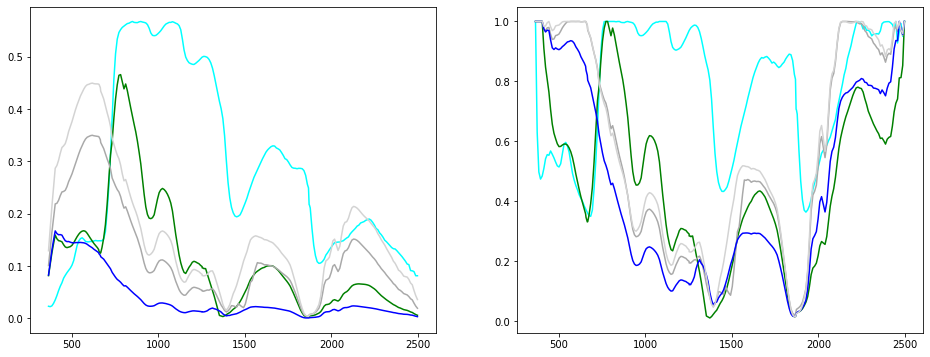

In [287]:
grassa_ethalon_imgspace_sig = grassa_ethalon.resample_at(wavelengths / 1000)
compare_plots_with_ethalon(grassa_ethalon_imgspace_sig, 'cyan')

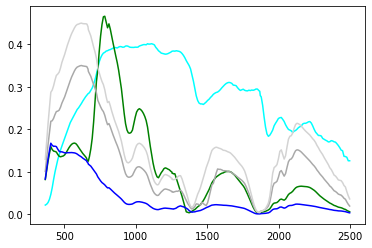

In [262]:
ethalon_imgspace_sig = SpectralData \
    .read_from_file('grass/splib07a_Grass_dry.9+.1green_AMX32_BECKa_AREF.txt') \
    .interpolate_invalid() \
    .resample_at(wavelengths_um)
compare_plots_with_ethalon(ethalon_imgspace_sig, 'cyan')

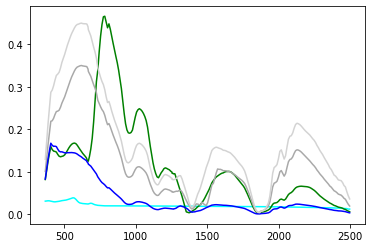

In [264]:
ethalon_imgspace_sig = SpectralData \
    .read_from_file('seawater/splib07a_Seawater_Coast_Chl_SW1_BECKa_AREF.txt') \
    .resample_at(wavelengths_um)

compare_plots_with_ethalon(ethalon_imgspace_sig, 'cyan')

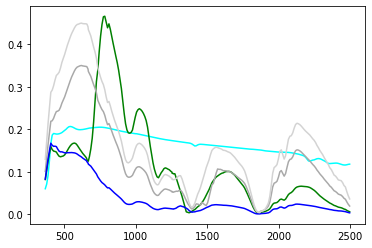

In [265]:
ethalon_imgspace_sig = SpectralData \
    .read_from_file('asphalt/splib07a_Asphalt_Shingle_GDS368_Lgray_ASDFRa_AREF.txt') \
    .resample_at(wavelengths_um)

compare_plots_with_ethalon(ethalon_imgspace_sig, 'cyan')

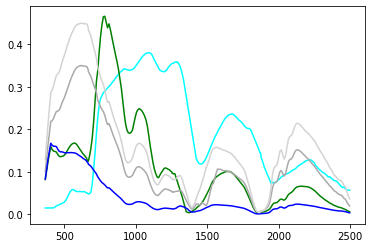

In [267]:
ethalon_imgspace_sig = SpectralData.read_from_file('grass/splib07a_Grass-FescueWheatg_YNP-FW-1_AVIRISb_RTGC.txt') \
        .interpolate_invalid() \
        .resample_at(wavelengths_um)

compare_plots_with_ethalon(ethalon_imgspace_sig, 'cyan')

Пока эталоны не совпадают. И не только в масштабе. Трава выглядит так:

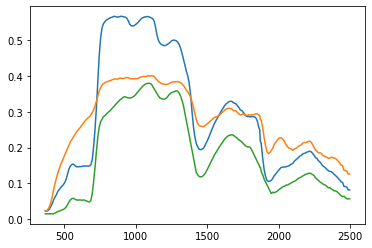

In [268]:
grass_files = ['grass/splib07a_Grass_dry.4+.6green_AMX27_BECKa_AREF.txt',
              'grass/splib07a_Grass_dry.9+.1green_AMX32_BECKa_AREF.txt',
              'grass/splib07a_Grass-FescueWheatg_YNP-FW-1_AVIRISb_RTGC.txt'
              ]

grass_sigs = [SpectralData.read_from_file(gf).interpolate_invalid().resample_at(wavelengths_um) \
                  for gf in grass_files]

draw_ontop(grass_sigs, wavelengths)